# Nurse scheduling problem 

## Implementing linear programming  algorithm to solve the NP-hard nurse scheduling problem. 


### Some basic constraints and assumptions:

* Each day is divided into 2 separate shifts of 12 hours (day/night).

* There are a number of required nurses for each of them. 

* A nurse is off on a specific day if no shift is assigned or if the nurse has requested a PTO on that specific day. 

* The planning length is 4 weeks (28 days). 
    
    * In this notebook, used 1 week instead for the purpose of convenience and easy visualization.

* Each nurse should work either 12, 24 or 36 hours hours per week.


### I personally add few more constraints:

* No nurse will work on both shifts in the single day.

* A nurse who works on a nigth shift will take the next day off.

* Max numbers of night shift for each nurse is at most ONE.

In [15]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tools.plotting import table
import os, sys, json
from pulp import *

%matplotlib inline

## Model:

* Essential idea is to introduce a binary variable ***x_ns*** in order to linearize the model

* Constraints and objective function can be represented as equality and inequality equations.

\begin{align}
    x_{ns}= 
        \begin{cases}
            0, &\text{nurse n will not work on shift s}\ \\
            1, &\text{nurse n will work on shift s}\
        \end{cases}
\end{align}

* s: each shift

* n: each nurse

* r: list storing the required nurses in each day.


\begin{align}
    \text{r} = [\text{number of nurses required in specific shift s}] \\
    \text{r[even index]} = [\text{number of nurses required in day shifts}] \\
    \text{r[odd index]} = [\text{number of nurses required in night shifts}] 
\end{align}

* PTO = Dictionary which stores the information of the off-work shifts(nurses requested PTO or other reasons)

\begin{align}
    \text{PTO} = \{n : [\text{list of off-work shifts for nurse n}]\}
\end{align}


* daily_shift: [0, 1] in this case(day = 0 /night = 1).

* working_shift = [1,2,3]: nurse works either 12, 24, 36 hours per week.

* planning_length: in this notebook, planning_length = 1. 

* Objective: minimize the numbers of scheduled nurses by satisfying all constraints. 

* Later on, preference of specific shifts/nurse and other constraints can be customized. 

* Implementing linear programming with pulp python package to find the solution of this constrained optimization problem. 

## Initializing the parameters

In [26]:
# nurse works either 12, 24, 36 hours per week.
working_shift = [1, 2, 3] 

# maximum shifts that nurse will work
max_shifts = 3

# planning_length
planning_length = 1 

# Numbers of shift per day:
daily_shift = [0, 1]

# Label the days from Monday to Sunday. 
d = ['M', 'Tu', 'W', 'Th', 'F','Sa','Su']

# Create the require_nurses dataframe
# day_nurse: Number of nurses required in day shift.
# night_nurse: Number of nurses required in night shift.
col = range(0, 7*planning_length)

require_nurses = pd.DataFrame(data = None, columns=d, index = daily_shift)

for j in col:
    # Small number is better for visualization.
    day_nurse, night_nurse = 5, 3
    require_nurses.iloc[0][j] = day_nurse
    require_nurses.iloc[1][j] = night_nurse

# List of number of nurses required in specific shift s

# r[even index]: required nurses in day shift
# r[odd index]: required nurses in night shift
r = require_nurses.values.swapaxes(0,1).ravel()

print "The number of nurses required for each shift is:" 
print r

print "\nIn matrix form:" 
print require_nurses.head()


# Total number of the nurses, at least more than sum(r)/3. Here use sum(r)/2.5
total = int(sum(r)/2.5)
print "\nTotal number of nurses are: {}".format(total)

# Create nurses_id tag
nurses_id = ['nurse'+str(i) for i in range(total)]
print "\nThe nurses are: "
print nurses_id

The number of nurses required for each shift is:
[5 3 5 3 5 3 5 3 5 3 5 3 5 3]

In matrix form:
   M Tu  W Th  F Sa Su
0  5  5  5  5  5  5  5
1  3  3  3  3  3  3  3

Total number of nurses are: 22

The nurses are: 
['nurse0', 'nurse1', 'nurse2', 'nurse3', 'nurse4', 'nurse5', 'nurse6', 'nurse7', 'nurse8', 'nurse9', 'nurse10', 'nurse11', 'nurse12', 'nurse13', 'nurse14', 'nurse15', 'nurse16', 'nurse17', 'nurse18', 'nurse19', 'nurse20', 'nurse21']


## Nurse is off on specific shifts: PTO dictionary

In [27]:
# nurse has requested a PTO on that specific day or whatever reasons. 

with open('utils/off_shift.json', 'r') as fp:
    off_shift = json.load(fp)
    
print off_shift

{u'10': [3], u'15': [2], u'0': [1], u'3': [12, 10], u'2': [0], u'5': [1], u'4': [7, 13]}


## Shifts and nurses lists

In [28]:
'''
shifts: label each shift. For example: Monday day shift is 0, Monday night shift is 1, Tuesday day shift is 2, etc.
nurses: label each nurse. Simply use integers to represent.
'''

shifts = range(2*7*planning_length)
nurses = range(total)

## Create shift names based on index:
shift_name = []
for s in shifts:
    # find the day shift or night shift
    n_or_day = 'n' if s%2 else 'd' 
    shift_name.append(d[s/2] + '_' + n_or_day)
    
print "The shifts are: " 
print shifts

print "\nThe names of corresponding shifts are: "
print shift_name

print "\nThe nurses are: "
print nurses

The shifts are: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

The names of corresponding shifts are: 
['M_d', 'M_n', 'Tu_d', 'Tu_n', 'W_d', 'W_n', 'Th_d', 'Th_n', 'F_d', 'F_n', 'Sa_d', 'Sa_n', 'Su_d', 'Su_n']

The nurses are: 
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


## Build constraint models:

* var = pulp.LpVariable(name, lowbound, upbound, cat="Binary")

* pb = pulp.LpProblem(name_str, sense = 'LpMaximize' or LpMinimize)


* problem.solve(pulp.solvers.GLPK(msg=0))

* check status: pulp.LpStatus(pb.status)

* pulp.value(pb.objective)

* Optimal solution: var.varValue

In [44]:
def LpProb():

    '''
    Use pulp to solve the constrained problem using linear programming(LP) algorithm. 
    1. Start the instance of a LpProblem: pulp.LpProblem(name_str, sense = 'LpMaxmize' or 'LpMinimize')
    2. Create LpVariables. Binary category in this case
    3. Add constraints in either equality or inequality conditions.
    4. Building objective using LpObjective. 
    5. Use Solver to solve the problem, display the status and optimized values.
    '''

    # The prob variable is created to contain the problem data   
    prob = LpProblem("Nurse scheduling",LpMinimize)
    
    # Creating the variables. 
    var = {
     (n, s): pulp.LpVariable(
        "schdule_{0}_{1}".format(n, s), cat = "Binary")
        for n in nurses for s in shifts
    }

    
    # add constraints: 
    # Nurses do not work in two consecutive shifts
    # If nurse works for a night shift, he/she will take a next day off

    for n in nurses:
        for s in shifts:
            if s%2 == 0:
                prob.addConstraint(
                var[(n,s)] + var[(n, s+1)] <= 1  # for day shift
               )
            elif s%2 == 1 and s < shifts[-1]:
                # night shift. Do not forget to add condition that the last
                # shift in the scheduling does not count.
                prob.addConstraint(
                var[(n, s)] + var[(n, s+1)]+var[(n, s+2)] <= 1
                )

    # add constraints:
    # Request PTO or take a specific day off:
    for n in nurses:
        if str(n) in off_shift:
            for s in off_shift[str(n)]:
                prob.addConstraint(
                var[(n, s)] == 0
                )

    # add constraints:
    # Working shift is either 1, 2 or 3
    # Here the first calculation is based on 
    for n in nurses:
        prob.addConstraint(
        sum(var[(n,s)] for s in shifts) <= 3    
        )
        prob.addConstraint(
        sum(var[(n,s)] for s in shifts) >= 1
        )

    # add constraints
    # Max numbers of night shift is one for each nurse

    for n in nurses:
        prob.addConstraint(
        sum(var[(n, s)] for s in shifts if s%2) <= 1
        )
    # add constraints
    # for each shift, the numbers of working nurses should be greater than
    # the required numbers of nurses
    for s in shifts:
        try:
            prob.addConstraint(
            sum(var[(n,s)] for n in nurses) >= r[s]
            )
        except:
            print "len(shifts) should be equal to len(require_nurses)"
            sys.exit(-1)   

            
    # add objective: minimize the numbers of total nurses required
    # nurse_working = []
    # for s in shifts:
    #     nurse_shift = sum(var[(n, s)] for n in nurses)
    #     nurse_working.append(
    #     pulp.LpVariable("nurses_%d"%(s,), cat = 'Integer', lowBound = 0)
    #     )
    prob.objective = sum(var[(n,s)] for n in nurses for s in shifts)    
    
    return var, prob

In [45]:
## Run the solver

var, prob = LpProb()
prob.solve()
print LpStatus[prob.status]

Optimal


## Check Constraints

In [60]:
def check_off_shift():
    # return True if the constraints have been satisfied otherwise return False

    for n in nurses:
        if str(n) in off_shift:
            for s in off_shift[str(n)]:
                if value(var[(n,s)]) == 1:
                    print n, s
                    return False

    for n in nurses:
        for s in shifts:
            if s%2 == 0:
                if value(var[(n,s)]) + value(var[(n, s+1)]) > 1:
                    return False  # for day shift
            elif s%2 == 1 and s < shifts[-1]:
                if value(var[(n,s)]) + value(var[(n,s+1)]) + value(var[(n, s+2)]) > 1:
                    return False

    for n in nurses:
        tmp = sum(value(var[(n,s)]) for s in shifts) 
        if tmp > 3 or tmp < 1:
            return False

    for n in nurses:
        if sum(value(var[(n, s)]) for s in shifts if s%2) > 1:
            return False

    for s in shifts:
        try:
            if sum(value(var[(n,s)]) for n in nurses) < r[s]:
                return False
        except:
            print "len(shifts) should be equal to len(require_nurses)"
            sys.exit(-1)   

    return True



print "Check the off_shift constraint: {}".format(check_off_shift())

Check the off_shift constraint: True


## Find the schedule for all nurses

In [46]:
def nurse_scheduling(var = var):

    schedule = pd.DataFrame(data=None, index = nurses_id, columns = shift_name)
    
    for k, v in var.items():
        n, s = k[0], k[1]
        schedule.iloc[n][s] = int(value(v)) # pulp.value()
        
    return schedule

In [47]:
schedule = nurse_scheduling()

schedule.head(5)

M_d M_n Tu_d Tu_n W_d W_n Th_d Th_n F_d F_n Sa_d Sa_n Su_d Su_n
nurse0   1   0    1    0   0   0    0    0   0   1    0    0    0    0
nurse1   0   1    0    0   0   0    1    0   1   0    0    0    0    0
nurse2   0   1    0    0   1   0    1    0   0   0    0    0    0    0
nurse3   0   0    1    0   0   0    0    0   0   0    0    0    0    1
nurse4   0   0    0    0   0   0    1    0   1   0    0    0    1    0

## Find out the schedule for each nurse

In [48]:
# Input the nurse id

def schedule_which_nurse(nurseWho, table = var):
    
    '''
    nurseWho: nurse id
    table: Either the schedule dataframe or the linear programming solution
    inputType: if 'lp': use linear programming solution
               else: the dataframe
    '''
    # Get the data for scheduling nurse n:
    sch = []
       
    for s in shifts:
        sch.append(
            int(value(table[(nurseWho, s)]))
            )
    
    sch = np.array(sch).reshape(len(sch)/2, 2).swapaxes(0, 1)
    
    df_sch = pd.DataFrame(sch, index = ['day', 'night'], columns = d)
    
    return df_sch
    

In [49]:
nurse0 = schedule_which_nurse(0)

print "The schedule for the nurse0 is:"

nurse0

The schedule for the nurse0 is:


M  Tu  W  Th  F  Sa  Su
day    1   1  0   0  0   0   0
night  0   0  0   0  1   0   0

## Visualize the schedule

In [50]:
def plot_table(df, figSize = (4,2), saveFig = False, figTitle = 'nurse_scheduling'):
     
    colors = df.applymap(lambda x: 'lightgray' if x== 0 else 'lightcoral') 

    fig = plt.figure(figsize=figSize)

    ax = plt.subplot(2, 1, 1, frame_on = True)  # no visible frame
    #ax.xaxis.set_visible(False)  # hide the x axis
    #ax.yaxis.set_visible(False)
    ax.axis('off')

    tb1 = table(ax,df,
                loc='center',
                cellLoc='center',
                cellColours=colors.as_matrix(),
                fontsize=14
          )

    if saveFig == True:
        if not os.path.isdir('figs/notebook/'):
            os.mkdir('figs/notebook/')
        plt.savefig('figs/notebook/'+ figTitle +'.png', bbox_inches='tight', dpi = 150)

    # refresh the plot
    plt.show()

The schedule of all nurses: 


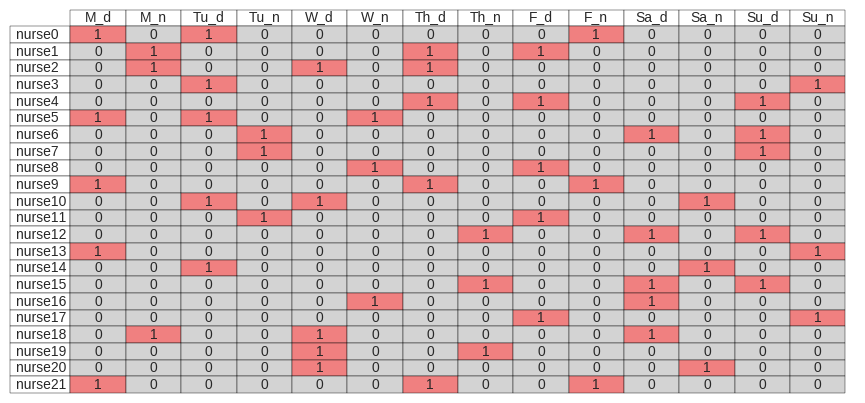

The required nurses are: 
[5 3 5 3 5 3 5 3 5 3 5 3 5 3]


In [51]:
print "The schedule of all nurses: "
plot_table(schedule, figSize = (10, 4), saveFig = True)

print "The required nurses are: "
print r

The schedule of nurses0


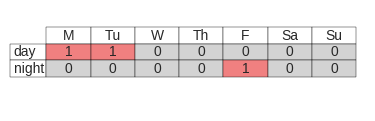

The schedule of nurses1


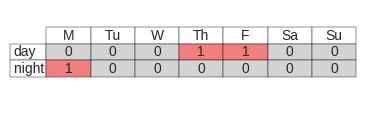

The schedule of nurses2


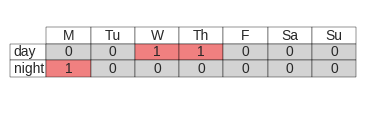

The schedule of nurses3


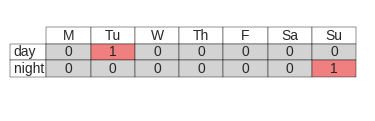

The schedule of nurses4


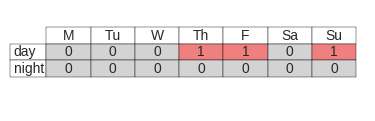

The schedule of nurses5


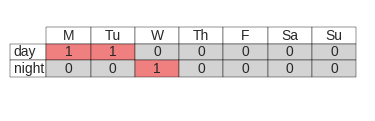

The schedule of nurses6


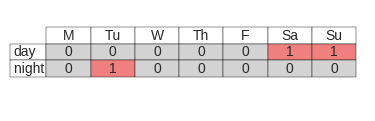

The schedule of nurses7


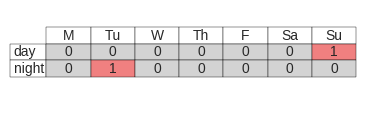

The schedule of nurses8


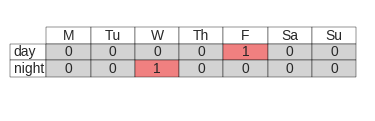

The schedule of nurses9


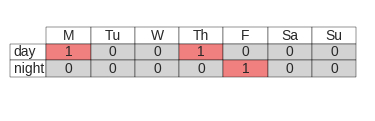

In [52]:
for n in nurses[:10]:
    print 'The schedule of nurses' + str(n)
    n0 = schedule_which_nurse(n)
    plot_table(n0, saveFig = True, figTitle = 'nurse' + str(n))

The schedule of nurses11


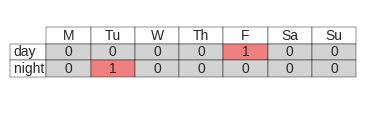

The schedule of nurses12


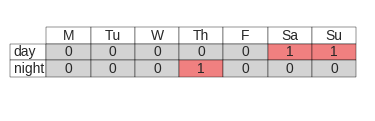

The schedule of nurses13


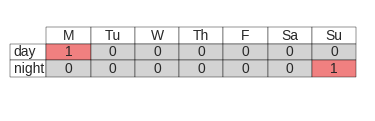

The schedule of nurses14


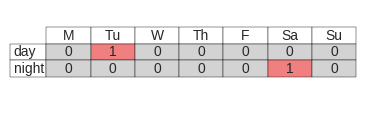

The schedule of nurses15


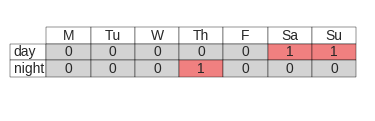

The schedule of nurses16


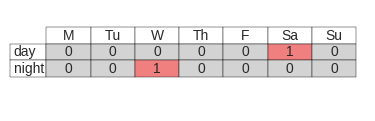

The schedule of nurses17


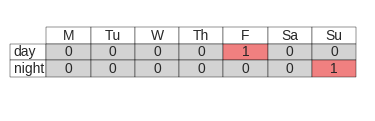

The schedule of nurses18


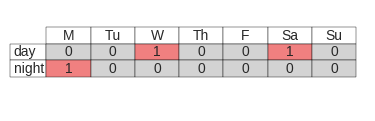

The schedule of nurses19


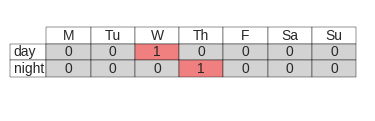

In [53]:
for n in nurses[11:20]:
    print 'The schedule of nurses' + str(n)
    n0 = schedule_which_nurse(n)
    plot_table(n0, saveFig = True, figTitle = 'nurse' + str(n))